# Project 4. Advanced lane finding


### 1. Import all the packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
from moviepy.editor import VideoFileClip
from collections import deque

%matplotlib inline

### 2. Undistort the images
The first step is to remove the distortion introduced by lense aberations in the image. For this we use a checker board pattern and few images of the checker board taken from the particular camera. Remember that for every camera we have to do this process. We then find the camera caliberation matrix and the distortion ofefficients from these images.

In [2]:
def show_comparison(image, function, gray=False):
    '''
    Method take an image and a modification function
    show the image before and after the modification
    '''
    
    image, modified_image = function(image)
#     print(image)
    figure, axes = plt.subplots(1, 2, figsize=(15,4))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image', fontsize=12)
#     axes[0].y_ticks=None

    if gray is True:
        axes[1].imshow(modified_image, cmap='gray')
    else:
        axes[1].imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Modified Image', fontsize=12)
    # turn off tricks
    

def compare_images(original_img, modified_img):
    '''
    Method take an image and a modification function
    show the image before and after the modification
    '''
    
    figure, axes = plt.subplots(1, 2, figsize=(15,4))
    axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image', fontsize=12)
    axes[1].imshow(cv2.cvtColor(modified_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Modified Image', fontsize=12)

In [3]:
inner_corners_count_x = 9
inner_corners_count_y = 6

calibration_images = glob.glob('camera_cal/calibration*.jpg')
road_images = glob.glob('test_images/test*.jpg')

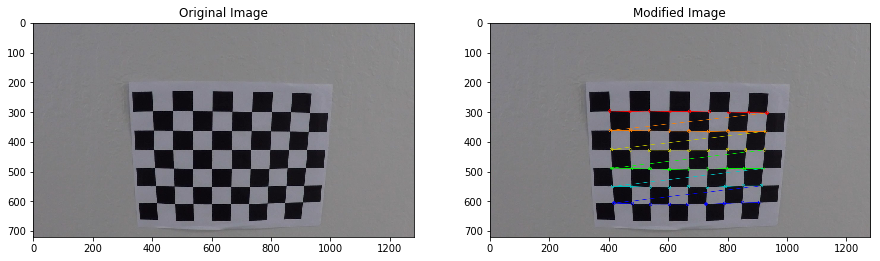

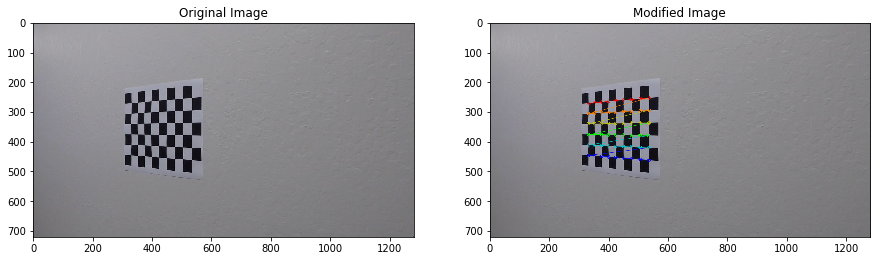

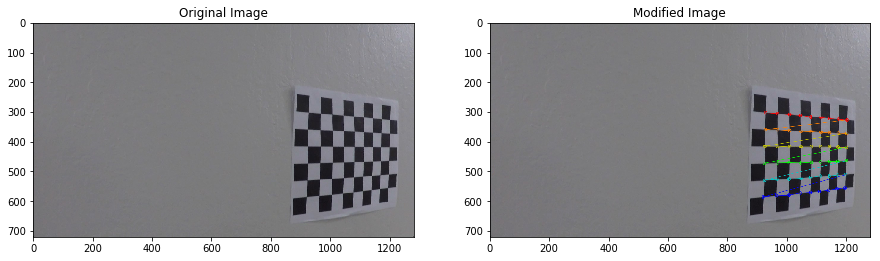

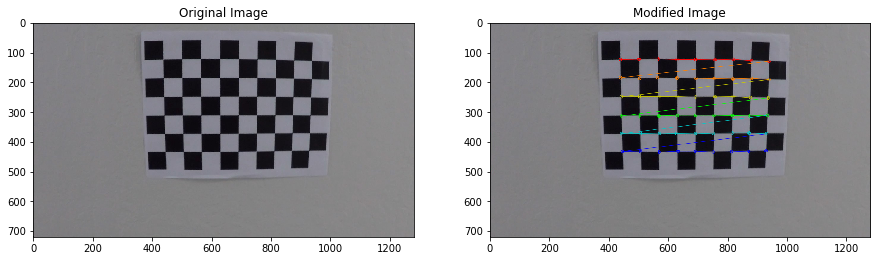

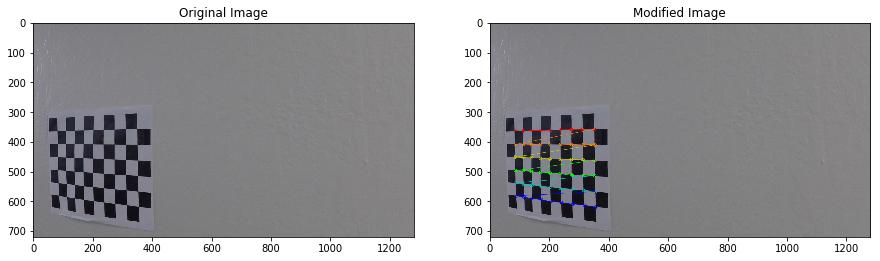

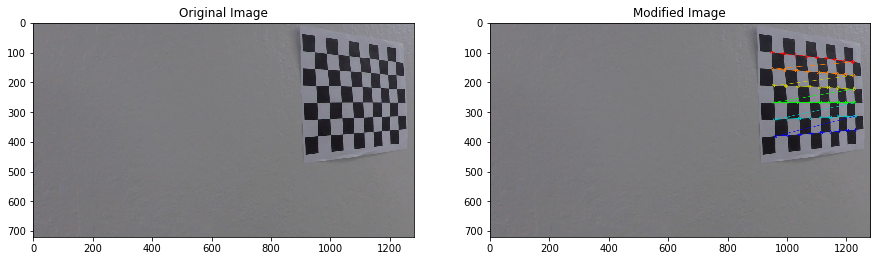

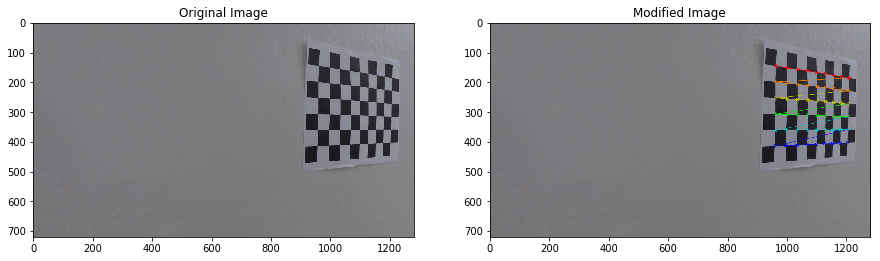

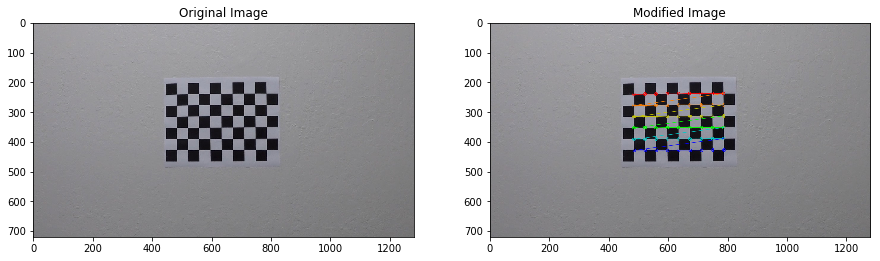

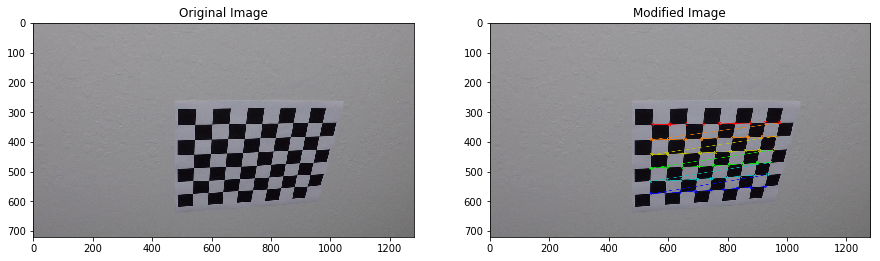

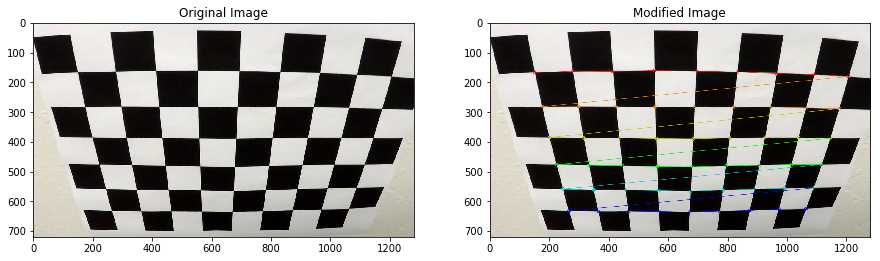

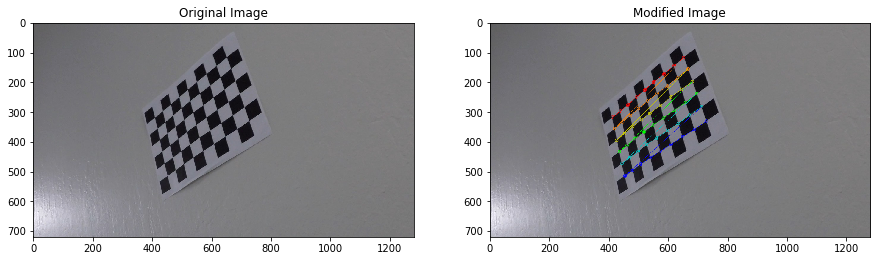

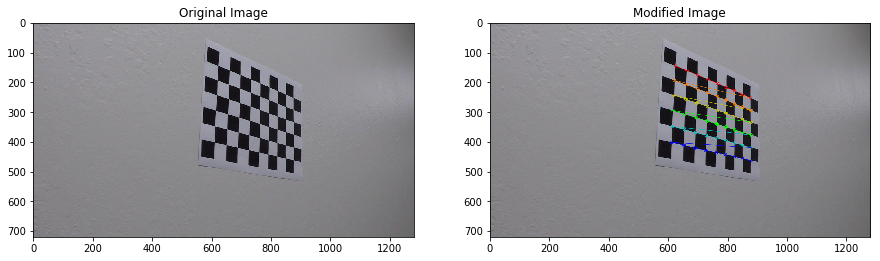

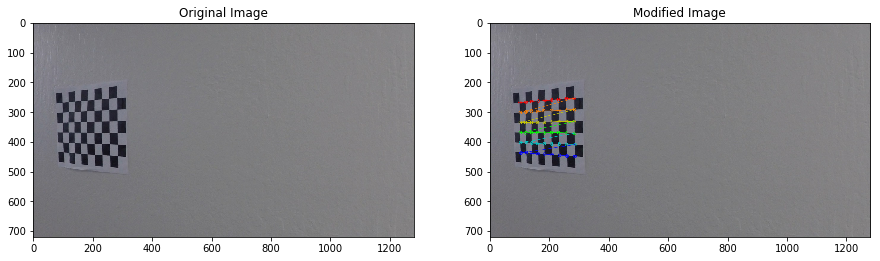

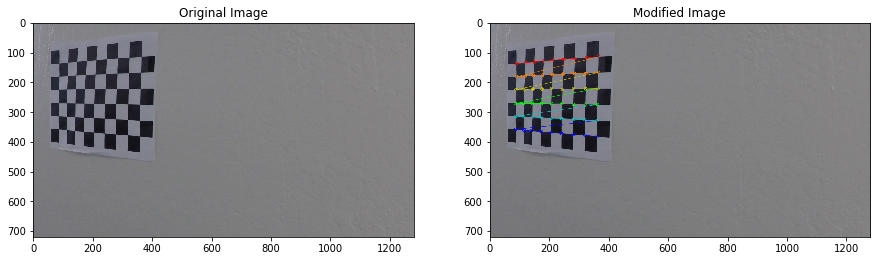

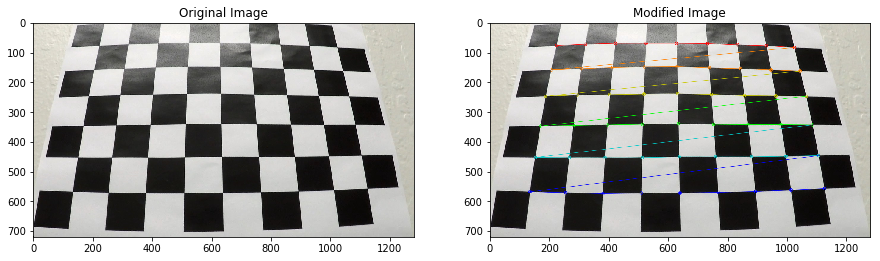

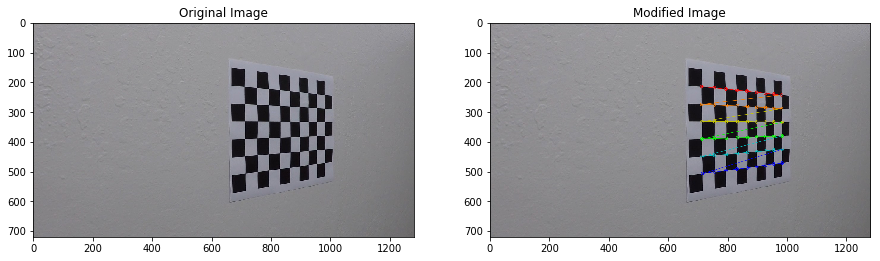

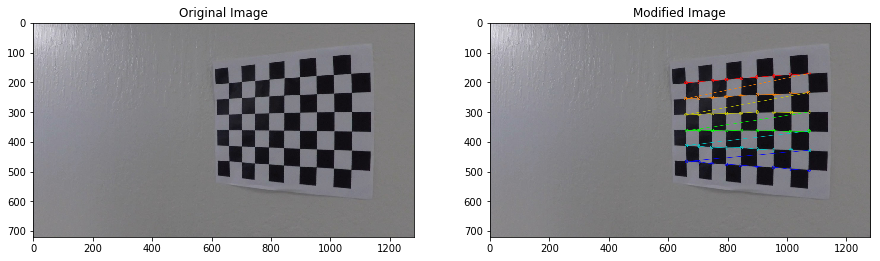

In [4]:


object_points = np.zeros(((inner_corners_count_x*inner_corners_count_y), 3), np.float32)
object_points[:,:2] = np.mgrid[0:inner_corners_count_x, 0:inner_corners_count_y].T.reshape(-1,2)

# print(object_points)

points_3d =[]
points_2d =[]

for i, image in enumerate(calibration_images):
    
    img = cv2.imread(image)
    img_dup = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Opencv function to find corners
    ret, corners = cv2.findChessboardCorners(gray, (inner_corners_count_x,inner_corners_count_y), None)
    
    # Finding corners if return is true
    if ret == True:
        points_3d.append(object_points)
        points_2d.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (inner_corners_count_x, inner_corners_count_y), corners, ret)
        
        compare_images(img_dup, img)

In [5]:
def undistort(image, show_grid=True):
    img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    
    if show_grid:
        #width /10
        img_x = int(img_size[0]/10)

        #height /10
        img_y = int(img_size[1]/10)

        # For visualizing the grid
        for i in range(10):
            cv2.line(img, (i* img_x, 0), (i* img_x, img_size[0]), (0, 0, 255), 3)
            cv2.line(img, (0, i* img_y), (img_size[0], i* img_y), (0, 0, 255), 3)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(points_3d, points_2d, img_size, None, None)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return img, undistort

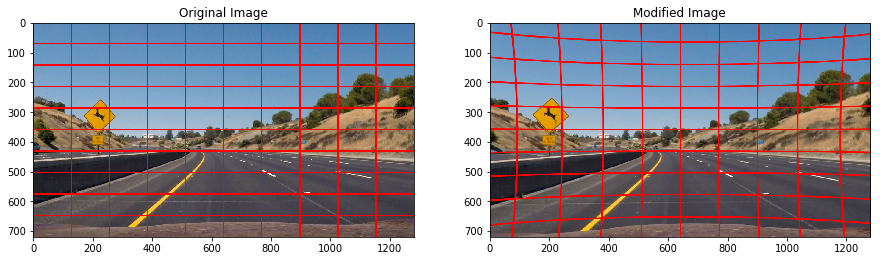

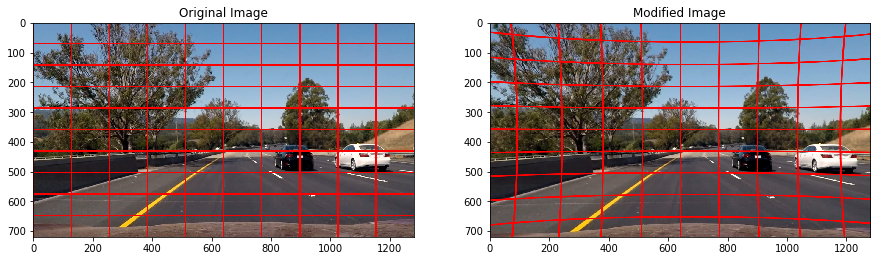

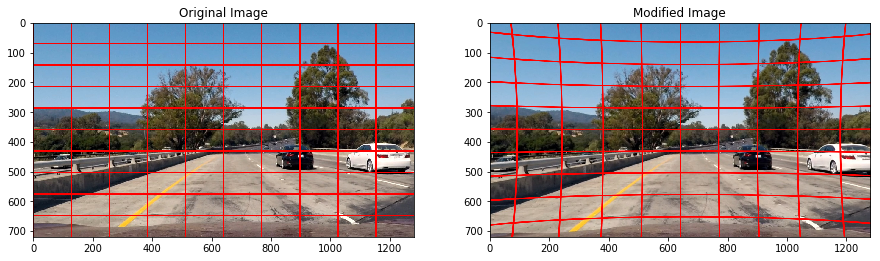

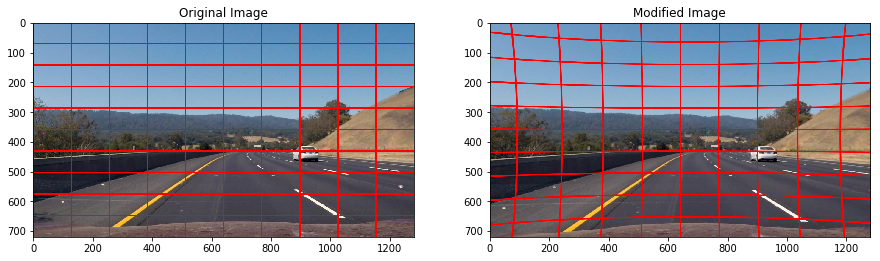

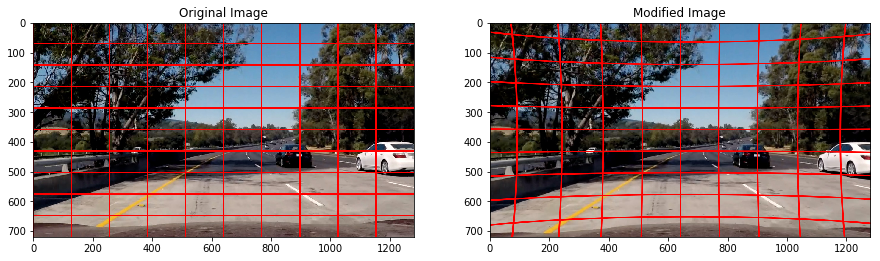

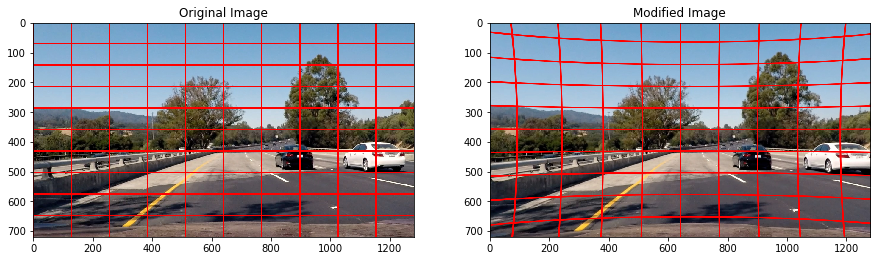

In [6]:
for image in road_images:
    show_comparison(image, undistort)

### 3. Take birds eye view of the lane lines
Next step is to transform the image image such that the lane lines become parellal. This transform is called birds eye transform. Transforming the image to birds eye view will later help easily fit polynomial on the lane lines

In [7]:
def birds_eye_transform(image, show_border=True):
    
    _, img = undistort(image, show_grid=False)
    
    if show_border:
        # For testing draw lines on the source image and see how they get transformed
        cv2.line(img, (510, 482), (790, 482), (0, 0, 255), 2)
        cv2.line(img, (790, 482), (1180, 680), (0, 0, 255), 2)
        cv2.line(img, (1180, 680), (110, 680), (0, 0, 255), 2)
        cv2.line(img, (110, 680), (510, 482), (0, 0, 255), 2)
        
    img_size = (img.shape[1], img.shape[0])

    src = np.float32([[510, 482],[790, 482],
                      [1180, 680],[110, 680]])
    
    dst = np.float32([[0, 0], [1280, 0], 
                     [1280, 720],[0, 720]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return img, warped

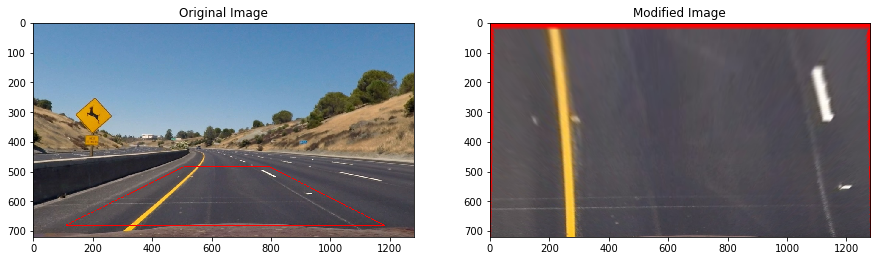

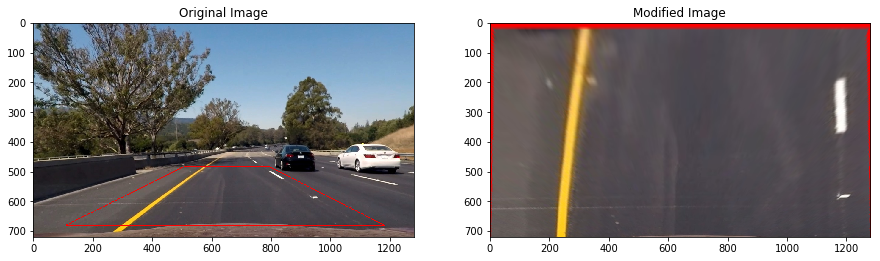

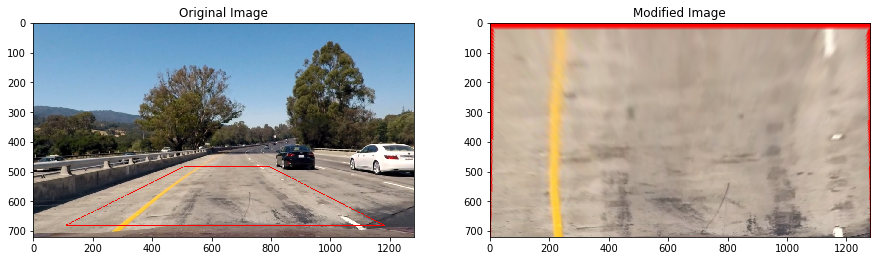

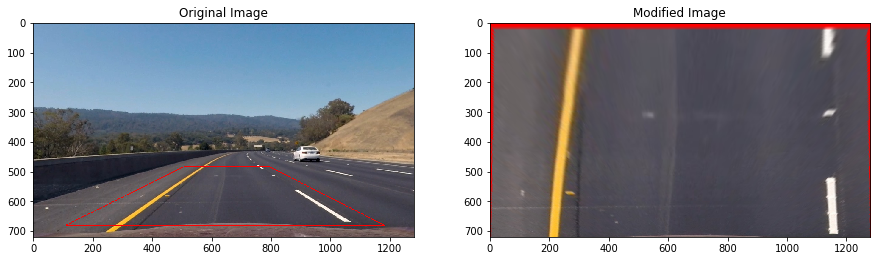

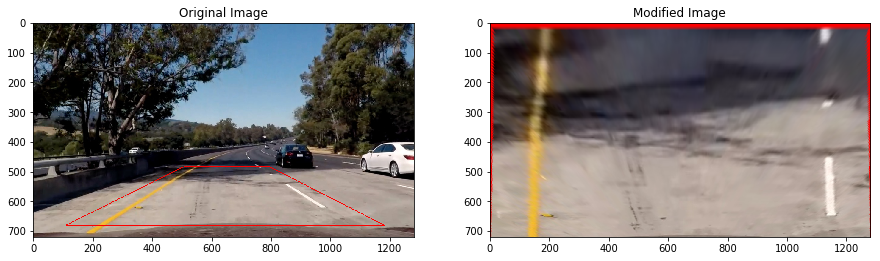

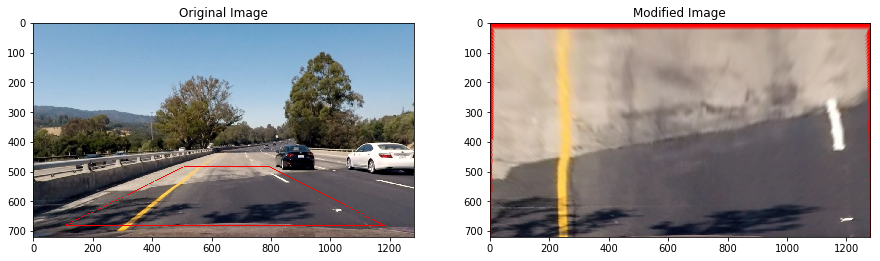

In [8]:
for image in road_images:
    show_comparison(image, birds_eye_transform)

### 4. Applying binary thresholds
In the bird eye view of the image we need to apply binary thresholding to isolate and identify the lane lines alone. This can be done by binary thresholding in different color spaces.

In [9]:
def binary_threshold(image):
    _, img = birds_eye_transform(image, show_border=False)
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(l_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    return img, combined_binary

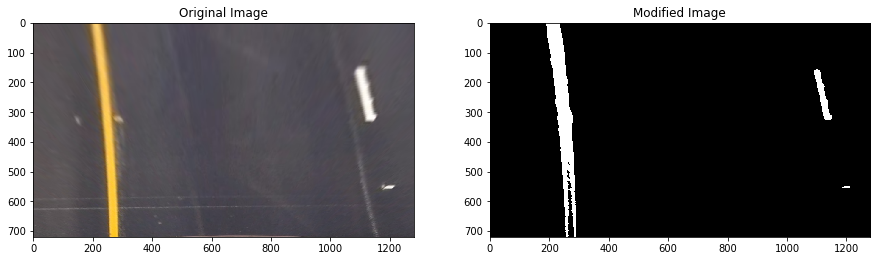

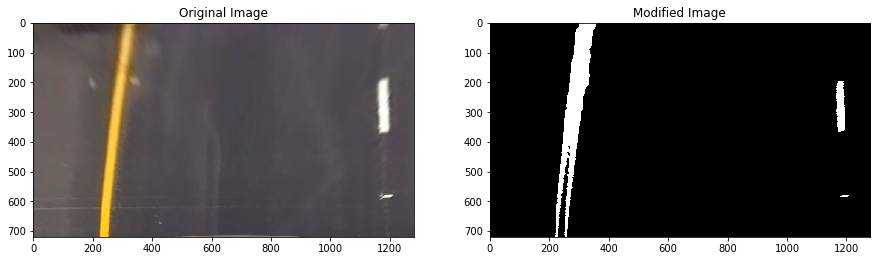

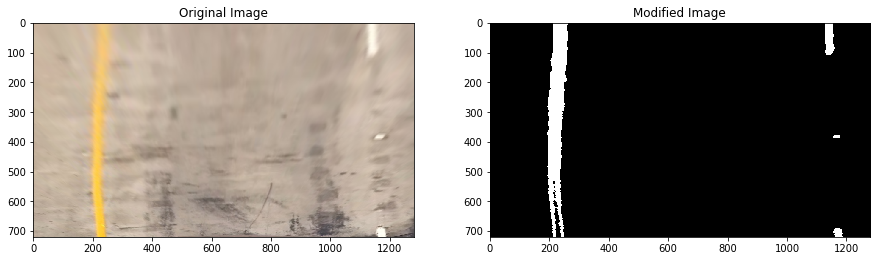

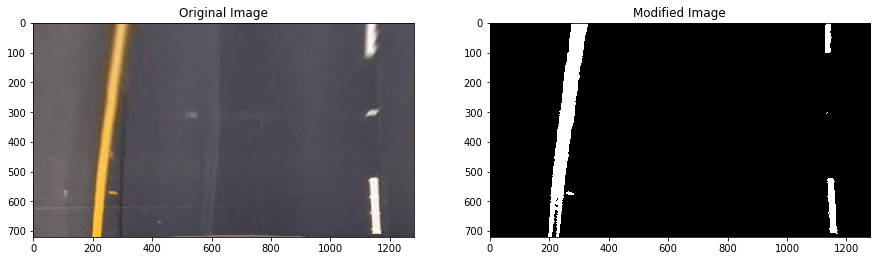

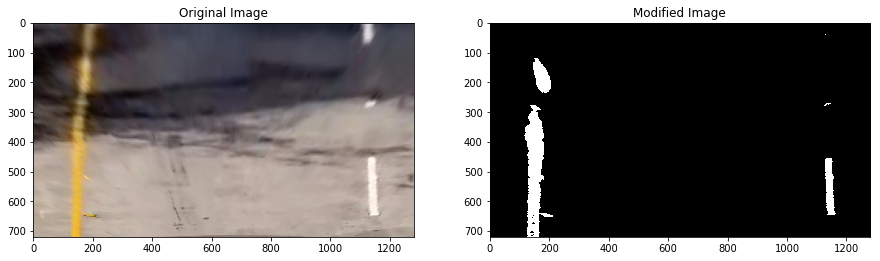

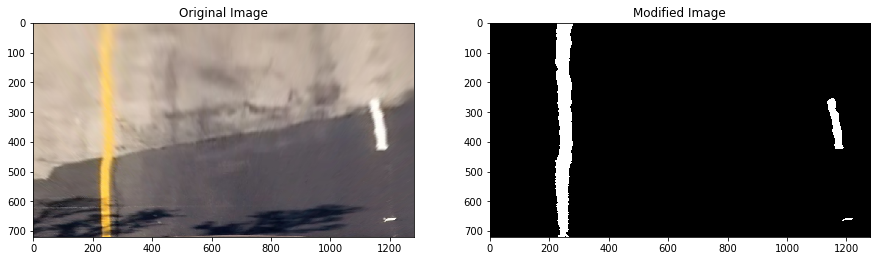

In [10]:
for image in road_images:
    show_comparison(image, binary_threshold, True)

In [93]:
def mark_lane(image):
    
    bird_img, test_img_bin = binary_threshold(image)
    bird_img_org = bird_img.copy()
    poses_left_x = []
    poses_left_y = []
    poses_right_x = []
    poses_right_y = []

    for i in range(test_img_bin.shape[0]):
        array_left = test_img_bin[i, :640]
        array_right = test_img_bin[i, 640:]
        pos_left = np.argmax(array_left)
        pos_right = np.argmax(array_right)
        if pos_left > 0:
            count_left = len(np.where(test_img_bin[1, :] == 1)[0])
            count_left = int(count_left/2)
            pos_left = pos_left + count_left
            poses_left_x.append(pos_left)
            poses_left_y.append(i)
#             cv2.circle(bird_img, (pos_left, i), 3, (255,255,255))
        if pos_right > 0:
            count_right = len(np.where(test_img_bin[1, :] == 1)[0])
            count_right = int(count_right/2)
            pos_right = pos_right + count_right
            poses_right_x.append(640 +pos_right)
            poses_right_y.append(i)
#             cv2.circle(bird_img, (640 + pos_right, i), 3, (255,255,255))

#     print('poses left x: ' , poses_left_x)
#     print('poses left y: ' , poses_left_y)
#     print('poses right x: ' , poses_right_x)
#     print('poses right y: ' , poses_right_y)

#     left_points_count = len(poses_left_x)
#     left_points_mid = int(left_points_count/2)
    
#     right_points_count = len(poses_right_x)
#     right_points_mid = int(right_points_count/2)
    
#     left_ys = [poses_left_y[0], poses_left_y[left_points_mid], poses_left_y[-1]]
#     left_xs = [poses_left_x[0], poses_left_x[left_points_mid], poses_left_x[-1]]
    
#     right_ys = [poses_right_y[0], poses_right_y[right_points_mid], poses_right_y[-1]]
#     right_xs = [poses_right_x[0], poses_right_x[right_points_mid], poses_right_x[-1]]

    left_poly = np.polyfit(poses_left_y, poses_left_x, 2)
    right_poly = np.polyfit(poses_right_y, poses_right_x, 2)

#     left_poly = np.polyfit(left_ys, left_xs, 2)
#     right_poly = np.polyfit(right_ys, right_xs, 2)

#     print(left_fit)
    return bird_img_org, bird_img, left_poly, right_poly


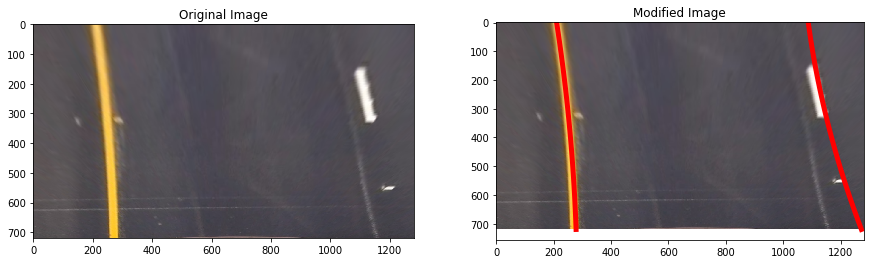

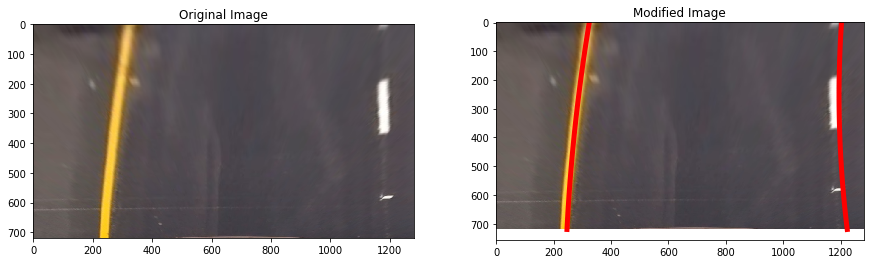

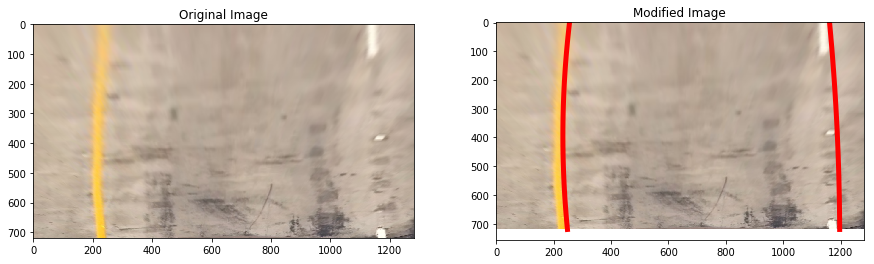

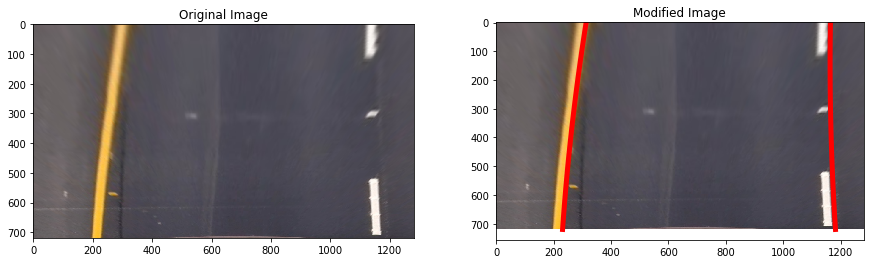

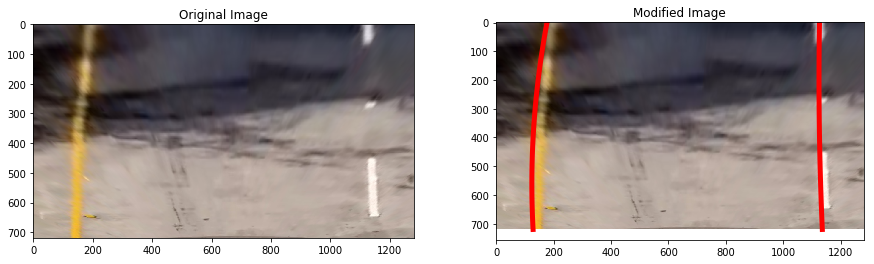

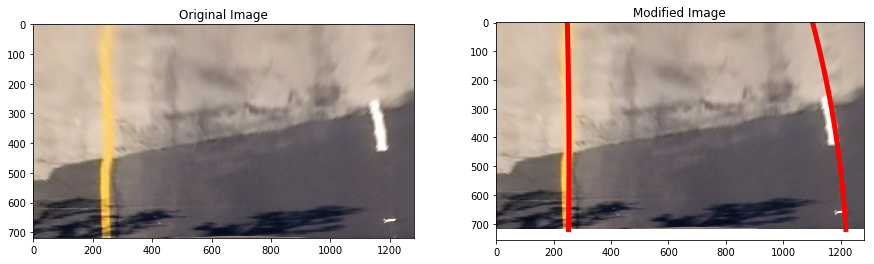

In [95]:
for image in road_images:
    org, trs, left_poly, right_poly = mark_lane(image)
    compare_images(org, trs)
    
    xp = np.linspace(0, 720, 100)
    
    p_left = np.poly1d(left_poly)
    p_right = np.poly1d(right_poly)
    xpy_left = p_left(xp)
    xpy_right = p_right(xp)
    plt.plot(xpy_left, xp, color='red', linewidth=5)
    plt.plot(xpy_right, xp, color='red', linewidth=5)
    plt.show()